In [364]:
import pandas as pd
import numpy as np
from functools import reduce
from ibllib.atlas import AllenAtlas
from ibllib.atlas.regions import BrainRegions
from matplotlib.colors import LinearSegmentedColormap
import dataframe_image as dfi
from ibllib.atlas.flatmaps import plot_swanson_vector
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import gridspec
from scipy import stats
ba = AllenAtlas()
br = BrainRegions()

# Load results

In [499]:
variable = "stimulus"
bwm_results = pd.read_pickle("Results/" + variable + "_results.pkl")  

# Set colormap for variable

In [500]:
if variable == "choice":
    colors = ["#F8E4AA","#F9D766","#E8AC22","#DA4727","#96371D"] # Choice
if variable == "stimulus":
    colors = ["#EAF4B3","#D5E1A0", "#A3C968", "#86AF40", "#517146","#33492E"]
if variable == "block":
    colors = ["#D0CDE4","#998DC3","#6159A6","#42328E", "#262054"]
if variable == "feedback":
    colors = ["#F1D3D0","#F5968A","#E34335","#A23535","#842A2A"]
cmap =  LinearSegmentedColormap.from_list("mycmap", colors)

# Reorder columns to match ordering in Figure

In [501]:
bwm_results = bwm_results[['euclidean_latency','euclidean_effect','glm_effect','mannwhitney_effect','decoding_effect']]

# Plot swanson maps

/Users/langdon/opt/anaconda3/envs/ibl_bwm/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


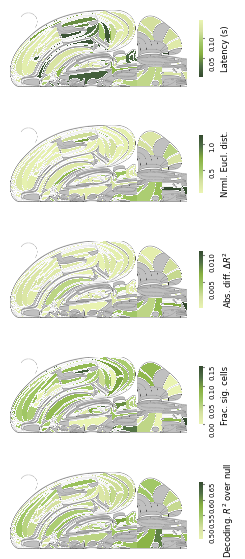

In [502]:
fig = plt.figure(figsize=(6,7))
gs = gridspec.GridSpec(5, 1, figure=fig,hspace=.5)
ax0 =fig.add_subplot(gs[0,0])
ax1 =fig.add_subplot(gs[1,0])
ax2 =fig.add_subplot(gs[2,0])
ax3 =fig.add_subplot(gs[3,0])
ax4 =fig.add_subplot(gs[4,0])

# Labels for colorbars
labels = ['Latency (s)',
         'Nrml. Eucl. dist.',
         'Abs. diff. ' + r'$\Delta R^2$',
         'Frac. sig. cells',
          'Decoding. ' + r'$R^2$' ' over null'
         ]
axes = [ax0,ax1,ax2,ax3,ax4]

# Plot each swanson panel    
for i in range(1,5):
    plot_swanson_vector(bwm_results.index.values,
                      bwm_results.iloc[:,i],
                      hemisphere="left",
                      cmap=cmap,
                      br=br,
                      ax=axes[i],
                     empty_color="silver")
    cbar=plt.colorbar(mappable=axes[i].images[0],shrink=0.75,aspect=12,pad=.025)
    cbar.ax.tick_params(labelsize=5,rotation=90)
    cbar.outline.set_visible(False)
    cbar.ax.tick_params(size=1)
    cbar.ax.xaxis.set_tick_params(pad=5)
    cbar.set_label(labels[i], fontsize=6)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].axis("off") 

# Plot latency panel separately since it has reversed colormap
plot_swanson_vector(bwm_results.index.values,
                      bwm_results.iloc[:,0],
                      hemisphere="left",
                      cmap=cmap.reversed(),
                      br=br,
                      ax=axes[0],
                     empty_color="silver")
cbar=plt.colorbar(mappable=axes[0].images[0],shrink=0.75,aspect=12,pad=.025)
cbar.ax.tick_params(labelsize=5,rotation=90)
cbar.outline.set_visible(False)
cbar.ax.tick_params(size=1)
cbar.ax.xaxis.set_tick_params(pad=5)
cbar.set_label(labels[0], fontsize=6)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].axis("off") 


# Save 
fig.savefig('swansons.jpg',
    format='jpg',
    dpi=1000,
)

# Plot comparison table

## Normalize values in each column to interval [0,1]
Pandas doesnt seem to automatically map values onto color map so I normalize them first.

In [503]:
bwm_results=(bwm_results-bwm_results.min())/(bwm_results.max()-bwm_results.min())

## Sum values in each row to use for sorting
The rows of the table are sorted by the sum of all effects across the row(excluding latency). Here we create a new column with this sum.

In [504]:
bwm_results['sum']  = bwm_results[['decoding_effect','mannwhitney_effect','euclidean_effect','glm_effect']].apply(np.sum,axis=1)
bwm_results = bwm_results.reset_index()

## Sort rows by 'sum' within each Cosmos region
The sorting by sum of effects is done within each Cosmos region. So here I add the cosmos acronym as a column, group and then sort 'sum'.

In [505]:
def beryl_to_cosmos(beryl_acronym,br):
    beryl_id = br.id[br.acronym==beryl_acronym]
    return br.get(ids=br.remap(beryl_id, source_map='Beryl', target_map='Cosmos'))['acronym'][0]

bwm_results['cosmos'] = bwm_results.region.apply(lambda x : beryl_to_cosmos(x,br))
bwm_results=bwm_results.groupby('cosmos').apply(lambda x: x.sort_values(['sum'], ascending=False))


## Add hex values for Beryl regions
Here I add a column of hex values corresponding to beryl acronyms. This is used to color each row by region.

In [506]:
def swanson_to_beryl_hex(beryl_acronym,br):
    beryl_id = br.id[br.acronym==beryl_acronym]
    rgb = br.get(ids=beryl_id)['rgb'][0].astype(int)
    return '#' + rgb_to_hex((rgb[0],rgb[1],rgb[2]))

def rgb_to_hex(rgb):
    return '%02x%02x%02x' % rgb

bwm_results['beryl_hex'] = bwm_results.region.apply(swanson_to_beryl_hex,args=[br])    
beryl_palette = dict(zip(bwm_results.region, bwm_results.beryl_hex))
bwm_results['region_color'] = bwm_results.region # Add dummy column to be colored according beryl rgb

## Order columns according to panels in Figure

In [507]:
bwm_results = bwm_results[['region','region_color','decoding_effect','mannwhitney_effect','glm_effect','euclidean_effect']]

## Format comparison table

In [508]:
def region_formatting(x):
    '''
    Formatting for acronym strings
    '''
    color = beryl_palette[x]
    return 'background-color: ' + color

def effect_formatting(x):
    '''
    Formatting for effect columns
    '''
    if pd.isna(x):
            color = 'silver'
    else:
        rgb = cmap(x)
        color =  '#' + rgb_to_hex((int(255*rgb[0]),int(255*rgb[1]),int(255*rgb[2])))
    return 'background-color: ' + color
        
# Format table  
def make_pretty(styler):

    styler.applymap(effect_formatting,subset=['decoding_effect','mannwhitney_effect','euclidean_effect','glm_effect'])
    styler.applymap(region_formatting,subset=['region_color'])
    styler.set_properties(subset=['region_color'], **{'width': '15px'})
    styler.set_properties(subset=['region_color'] , **{'font-size': '0pt'})
    styler.set_properties(subset=['decoding_effect','euclidean_effect','mannwhitney_effect','glm_effect'], **{'width': '12px'})
    styler.set_properties(subset=['region'], **{'width': '25px'})
    styler.set_properties(subset=['decoding_effect','euclidean_effect','mannwhitney_effect','glm_effect'] , **{'font-size': '0pt'})
    styler.set_properties(subset=['region'] , **{'font-size': '8pt'})
    styler.hide(axis="index")
    styler.set_table_styles([
    {"selector": "tr", "props": "line-height: 8px"},
    {"selector": "td,th", "props": "line-height: inherit; padding: 0 "},
        {"selector": "", "props": [("border", "1px solid white")]},
        {"selector": "tbody td", "props": [("border", "1px solid white")]},
        {'selector': 'thead', 'props': [('display', 'none')]}
    ])
    return styler

## Plot table

In [509]:
styled_bwm_results = bwm_results.style.pipe(make_pretty)
dfi.export(styled_bwm_results, 'df_styled.png',max_rows = -1)
styled_bwm_results

/Users/langdon/opt/anaconda3/envs/ibl_bwm/lib/python3.9/site-packages/dataframe_image/_pandas_accessor.py:69: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  html = '<div>' + obj.render() + '</div>'
objc[72134]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffb4537fec8) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/110.0.5481.177/Libraries/libGLESv2.dylib (0x10d77d220). One of the two will be used. Which one is undefined.
[0306/164434.219265:INFO:headless_shell.cc(107)] 63745 bytes written to file /var/folders/_9/nhd6c9g15y1bwpn7w82xcz8r0000gp/T/tmpvjh6e5yp/temp.png
objc[72148]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffb4537fec8) and /Applicat

region,region_color,decoding_effect,mannwhitney_effect,glm_effect,euclidean_effect
SIM,SIM,0.406285,0.538776,0.148792,0.205007
ANcr1,ANcr1,0.405725,0.511628,0.057760,0.142902
CENT2,CENT2,0.284407,0.295522,0.101530,0.256044
IP,IP,0.557160,0.000000,0.071783,0.193161
PRM,PRM,0.280903,0.000000,0.213607,0.308114
CUL4 5,CUL4 5,0.234375,0.270000,0.097252,0.163548
COPY,COPY,0.261293,0.000000,0.258692,0.164720
NOD,NOD,0.290565,0.000000,0.017965,0.094485
GPe,GPe,0.468846,0.455172,0.345330,0.519372
CP,CP,0.361961,0.503752,0.300760,0.122150
